# Quantum Tomography - analysis of Inclusive ALICE data

This is the analysis code to measure the polarisation of a vector meson using Quantum Tomography. The data here used were taken from HERA.

In [1]:
import os
import sys
import warnings
import matplotlib.pyplot as plt
import pickle
import uproot
import numpy as np
import pandas as pd
# import xgboost as xgb
import sklearn

sys.path.insert(0, '../')
# import analysis_utils as au

# avoid pandas warning
warnings.simplefilter(action='ignore', category=FutureWarning)

## Four-momentum logic

In [2]:
import skhep
from skhep import math


# Levi-Civita symbol
import sympy
from sympy import LeviCivita

Quantum tomography works by defining three coordinate axes in a Lorentz-invariant approach.

Using \\( k_+^\mu \\), \\(k_-^\mu \\) for the positive and the negative muon, respectively, we construct the vector meson 4-vector \\( Q^\mu \\) as:

\\[ Q^\mu = k_+^\mu + k_-^\mu \\]

If \\( p_A^\mu, p_B^\mu \\) are the two beams, the three axes \\( X^\mu, Y^\mu, Z^\mu \\) are defined as:

\\[ Z^\mu = p_A^\mu  Q{\cdot}p_B - p_B^\mu Q{\cdot}p_A \\]

\\[ Y^\mu = \epsilon^{\mu\nu\alpha\beta}p_{A \nu}p_{B \alpha}Q_\beta \\]

\\[ X^\mu = Q^\mu - p_A^\mu \frac{Q^2}{2Q{\cdot}p_A} - p_B^\mu \frac{Q^2}{2Q{\cdot}p_B} \\]





## Probe matrix
The probe matrix \\(\rho(l)\\) is defined as follows:
\\[\rho(l) = \frac{1+a}{3}\cdot \delta_{ij} - a{\cdot}l_i\cdot l_j - ib\cdot \epsilon_{ijk}\cdot l_k,\\]
where \\(a = 0.5\\) and \\(b = c_A{\cdot}c_V = \sin^2\theta_W \simeq 0.22\\).

In [3]:
from numpy import linalg as al
from numpy.linalg import eig as eig

In [4]:
#7    TeV pp  : https://arxiv.org/pdf/1111.1630.pdf
#8    TeV pp  : https://arxiv.org/pdf/1805.04374.pdf
#5.02 TeV PbPb: https://arxiv.org/pdf/2005.11128.pdf

data_inclusive = { 'E'             : [  7,     7,    7,     7,     7,     7,     8,      8,      8,      8,      8,      8,      8,      8,      8,      8,      8,      8,      5,      5,      5,      5,      5,      5,      7,      7,      7,      7,      7,      7,      7,      7,      7,      7     ],
                   'Frame'         : [  0,     0,    0,     1,     1,     1,     0,      0,      0,      0,      0,      0,      1,      1,      1,      1,      1,      1,      0,      0,      0,      1,      1,      1,      1,      1,      1,      1,      1,      1,      1,      1,      1,      1     ],
                   '<pT>'          : [  2.00,  3.00, 4.00,  2.00,  3.00,  4.00,  2.00,   3.00,   4.00,   5.00,   7.00,  10.00,   2.00,   3.00,   4.00,   5.00,   7.00,  10.00,   2.00,   4.00,   6.00,   2.00,   4.00,   6.00,  14.0,   16.,    18.,    20.,    22.,    25.,    30.,    35.,    40.,    50.    ],
                   'Ltheta'        : [ -0.36, -0.20, 0.00, -0.10, -0.06, -0.09,  0.035, -0.085,  0.083, -0.036, -0.092, -0.329,  0.002, -0.011,  0.001,  0.063,  0.175, -0.021,  0.218,  0.151, -0.070, -0.157, -0.057, -0.008, -0.116, -0.062, -0.102, -0.066, -0.107, -0.049, -0.227, -0.048, -0.154, -0.084 ],
                   'Lphi'          : [  0.05,  0.01, 0.00, -0.04, -0.03,  0.03, -0.037, -0.065, -0.003,  0.055,  0.090, -0.003, -0.030, -0.065, -0.019, -0.020,  0.001, -0.052, -0.029, -0.013,  0.047,  0.061,  0.047,  0.024,  0.087,  0.024,  0.079,  0.028,  0.068,  0.02,   0.145,  0.06,   0.026, -0.045 ],
#                    'Lthetaphi'     : [  None,  None, None,  None,  None,  None, -0.024, -0.080, -0.024, -0.001,  0.089,  0.222,  0.041, -0.075,  0.006, -0.042, -0.009, -0.065],
                   'Lthetaphi'     : [  0,     0,    0,     0,     0,     0,    -0.024, -0.080, -0.024, -0.001,  0.089,  0.222,  0.041, -0.075,  0.006, -0.042, -0.009, -0.065, -0.124, -0.059, -0.025, -0.090, -0.040,  0.018,  0.001, -0.03,  -0.017, -0.001, -0.009,  0.003,  0.029,  0.014,  0.022, -0.035 ],
                   'StatLtheta'    : [  0.09,  0.11, 0.10,  0.14,  0.14,  0.10,  0.048,  0.053,  0.066,  0.058,  0.078,  0.121,  0.046,  0.052,  0.056,  0.048,  0.070,  0.110,  0.060,  0.071,  0.068,  0.049,  0.059,  0.063,  0.0245, 0.024,  0.0255, 0.028,  0.027,  0.029,  0.033,  0.057,  0.0575, 0.091 ],
                   'StatLphi'      : [  0.04,  0.05, 0.04,  0.08,  0.08,  0.06,  0.025,  0.026,  0.033,  0.029,  0.039,  0.070,  0.024,  0.026,  0.030,  0.031,  0.045,  0.084,  0.017,  0.019,  0.021,  0.015,  0.024,  0.032,  0.0245, 0.0245, 0.0245, 0.028,  0.0255, 0.025,  0.0295, 0.043,  0.044,  0.0635],
#                    'StatLthetaphi' : [  None,  None, None,  None,  None,  None,  0.032,  0.035,  0.043,  0.039,  0.055,  0.099,  0.032,  0.035,  0.041,  0.041,  0.060,  0.110],
                   'StatLthetaphi' : [  0,     0,    0,     0,     0,     0,     0.032,  0.035,  0.043,  0.039,  0.055,  0.099,  0.032,  0.035,  0.041,  0.041,  0.060,  0.110,  0.028,  0.030,  0.031,  0.027,  0.034,  0.035,  0.0085, 0.0095, 0.011,  0.0125, 0.013,  0.0145, 0.020,  0.029,  0.0305, 0.048 ],
                   'SysLtheta'     : [  0.21,  0.13, 0.10,  0.13,  0.07,  0.08,  0.215,  0.189,  0.188,  0.154,  0.168,  0.130,  0.228,  0.185,  0.124,  0.088,  0.096,  0.106,  0.087,  0.068,  0.047,  0.058,  0.055,  0.026,  0.109,  0.085,  0.0695, 0.0605, 0.058,  0.084,  0.0905, 0.109,  0.1015, 0.1325],
                   'SysLphi'       : [  0.04,  0.05, 0.04,  0.07,  0.05,  0.07,  0.093,  0.134,  0.096,  0.069,  0.056,  0.052,  0.095,  0.098,  0.086,  0.087,  0.082,  0.077,  0.031,  0.036,  0.010,  0.033,  0.023,  0.018,  0.1065, 0.0795, 0.0685, 0.0625, 0.058,  0.0525, 0.055,  0.0665, 0.0665, 0.085 ],
#                    'SysLthetaphi'  : [  None,  None, None,  None,  None,  None,  0.082,  0.077,  0.080,  0.078,  0.082,  0.079,  0.076,  0.084,  0.080,  0.082,  0.096,  0.098]                  
                   'SysLthetaphi'  : [  0,     0,    0,     0,     0,     0,     0.082,  0.077,  0.080,  0.078,  0.082,  0.079,  0.076,  0.084,  0.080,  0.082,  0.096,  0.098,  0.043,  0.021,  0.030,  0.029,  0.046,  0.044,  0.0325, 0.0325, 0.033,  0.032,  0.028,  0.0275, 0.037,  0.039,  0.0435, 0.057 ]                  

         } 
                                                                                                                        
                                                                                                                        
                                                                                                                        
                                      
df_inclusive = pd.DataFrame(data=data_inclusive)
df_inclusive

                
                                                                                                                        

,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,SysLphi,SysLthetaphi
0,7,0,2.0,-0.360,0.050,0.000,0.0900,0.0400,0.0000,0.2100,0.0400,0.0000
1,7,0,3.0,-0.200,0.010,0.000,0.1100,0.0500,0.0000,0.1300,0.0500,0.0000
2,7,0,4.0,0.000,0.000,0.000,0.1000,0.0400,0.0000,0.1000,0.0400,0.0000
3,7,1,2.0,-0.100,-0.040,0.000,0.1400,0.0800,0.0000,0.1300,0.0700,0.0000
4,7,1,3.0,-0.060,-0.030,0.000,0.1400,0.0800,0.0000,0.0700,0.0500,0.0000
5,7,1,4.0,-0.090,0.030,0.000,0.1000,0.0600,0.0000,0.0800,0.0700,0.0000
6,8,0,2.0,0.035,-0.037,-0.024,0.0480,0.0250,0.0320,0.2150,0.0930,0.0820
7,8,0,3.0,-0.085,-0.065,-0.080,0.0530,0.0260,0.0350,0.1890,0.1340,0.0770
8,8,0,4.0,0.083,-0.003,-0.024,0.0660,0.0330,0.0430,0.1880,0.0960,0.0800
9,8,0,5.0,-0.036,0.055,-0.001,0.0580,0.0290,0.0390,0.1540,0.0690,0.0780


In [5]:
def ConvertToRho33( LambdaTheta ):
    RhoZero = (1.-LambdaTheta)/(3. + LambdaTheta)
    return RhoZero

def ConvertToRho33Uncert( LambdaTheta, LambdaThetaUncert ):
    DeltaRhoZero = 4.*LambdaThetaUncert /((3. + LambdaTheta) * (3. + LambdaTheta))
    return DeltaRhoZero



def ConvertToRho22( LambdaTheta, LambdaPhi ):
    RhoTwo = (2.*LambdaPhi + LambdaTheta + 1.)/(3. + LambdaTheta)
    return RhoTwo

def ConvertToRho22Uncert( LambdaTheta, LambdaThetaUncert, LambdaPhi, LambdaPhiUncert ):
    DeltaRhoTwo = math.sqrt( (2.*LambdaPhi*LambdaThetaUncert/((3. + LambdaTheta)*(3. + LambdaTheta)))*(2.*LambdaPhi*LambdaThetaUncert/((3. + LambdaTheta)*(3. + LambdaTheta)))    +   ( 2.*LambdaPhiUncert/(3. + LambdaTheta) )*( 2.*LambdaPhiUncert/(3. + LambdaTheta) ))            
    return DeltaRhoTwo



def ConvertToRho13( LambdaTheta, LambdaThetaPhi ):
    RhoTwo = (-2.*LambdaThetaPhi)/(3. + LambdaTheta)
    return RhoTwo

def ConvertToRho13Uncert( LambdaTheta, LambdaThetaUncert, LambdaThetaPhi, LambdaThetaPhiUncert ):
    DeltaRho13 = math.sqrt( (2.*LambdaThetaPhiUncert/(3. + LambdaTheta))*(2.*LambdaThetaPhiUncert/(3. + LambdaTheta))    +   ( 2.*LambdaThetaPhi*LambdaThetaUncert/((3. + LambdaTheta)*(3. + LambdaTheta) ))*( 2.*LambdaThetaPhi*LambdaThetaUncert/((3. + LambdaTheta)*(3. + LambdaTheta) )           )   )         
    return DeltaRho13




# def ConvertToRho11( LambdaTheta, LambdaThetaPhi ):
#     Rho11 = (4.*LambdaThetaPhi*LambdaThetaPhi)/(3. - 2.*LambdaTheta - LambdaTheta*LambdaTheta)
#     return Rho11
def ConvertToRho11( Rho22, Rho33 ):
    Rho11 = 1.-Rho22-Rho33
    return Rho11

def ConvertToRho11Uncert( LambdaTheta, LambdaThetaUncert, LambdaThetaPhi, LambdaThetaPhiUncert ):
    A = (8.*LambdaThetaPhi*LambdaThetaPhiUncert/(3. - 2.*LambdaTheta - LambdaTheta*LambdaTheta))
    B = (4.*LambdaThetaPhi*LambdaThetaPhi*LambdaThetaUncert)*(-2.-LambdaTheta)/( (3. - 2.*LambdaTheta - LambdaTheta*LambdaTheta)*(3. - 2.*LambdaTheta - LambdaTheta*LambdaTheta) )
    DeltaRho11 = math.sqrt( A*A + B*B )
    return DeltaRho11


In [6]:
df_inclusive['Rho33']     = df_inclusive.apply(lambda x: ConvertToRho33(       x['Ltheta']                             ), axis=1)
df_inclusive['Rho22']     = df_inclusive.apply(lambda x: ConvertToRho22(       x['Ltheta'],      x['Lphi']             ), axis=1)
df_inclusive['Rho13']     = df_inclusive.apply(lambda x: ConvertToRho13(       x['Ltheta'],      x['Lthetaphi']        ), axis=1)
# df_inclusive['Rho11']     = df_inclusive.apply(lambda x: ConvertToRho11(       x['Ltheta'],      x['Lthetaphi']        ), axis=1)
df_inclusive['Rho11']     = df_inclusive.apply(lambda x: ConvertToRho11(       x['Rho22'],       x['Rho33']        ), axis=1)
df_inclusive['Rho33stat'] = df_inclusive.apply(lambda x: ConvertToRho33Uncert( x['Ltheta'],      x['StatLtheta']       ), axis=1)
df_inclusive['Rho33sys']  = df_inclusive.apply(lambda x: ConvertToRho33Uncert( x['Ltheta'],      x['SysLtheta']        ), axis=1)
df_inclusive['Rho22stat'] = df_inclusive.apply(lambda x: ConvertToRho22Uncert( x['Ltheta'],      x['StatLtheta'],  x['Lphi'],           x['StatLphi']       ), axis=1)
df_inclusive['Rho22sys']  = df_inclusive.apply(lambda x: ConvertToRho22Uncert( x['Ltheta'],      x['SysLtheta'],   x['Lphi'],           x['SysLphi']        ), axis=1)
df_inclusive['Rho13stat'] = df_inclusive.apply(lambda x: ConvertToRho13Uncert( x['Ltheta'],      x['StatLtheta'],  x['Lthetaphi'],      x['StatLthetaphi']  ), axis=1)
df_inclusive['Rho13sys']  = df_inclusive.apply(lambda x: ConvertToRho13Uncert( x['Ltheta'],      x['SysLtheta'],   x['Lthetaphi'],      x['SysLthetaphi']   ), axis=1)
df_inclusive['Rho11stat'] = df_inclusive.apply(lambda x: ConvertToRho11Uncert( x['Ltheta'],      x['StatLtheta'],  x['Lthetaphi'],      x['StatLthetaphi']  ), axis=1)
df_inclusive['Rho11sys']  = df_inclusive.apply(lambda x: ConvertToRho11Uncert( x['Ltheta'],      x['SysLtheta'],   x['Lthetaphi'],      x['SysLthetaphi']   ), axis=1)

df_inclusive






,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho13,Rho11,Rho33stat,Rho33sys,Rho22stat,Rho22sys,Rho13stat,Rho13sys,Rho11stat,Rho11sys
0,7,0,2.0,-0.360,0.050,0.000,0.0900,0.0400,0.0000,0.2100,...,-0.000000,0.204545,0.051653,0.120523,0.030331,0.030452,0.000000,0.000000,0.000000,0.000000
1,7,0,3.0,-0.200,0.010,0.000,0.1100,0.0500,0.0000,0.1300,...,-0.000000,0.278571,0.056122,0.066327,0.035715,0.035716,0.000000,0.000000,0.000000,0.000000
2,7,0,4.0,0.000,0.000,0.000,0.1000,0.0400,0.0000,0.1000,...,-0.000000,0.333333,0.044444,0.044444,0.026667,0.026667,0.000000,0.000000,0.000000,0.000000
3,7,1,2.0,-0.100,-0.040,0.000,0.1400,0.0800,0.0000,0.1300,...,-0.000000,0.337931,0.066587,0.061831,0.055188,0.048292,0.000000,0.000000,0.000000,0.000000
4,7,1,3.0,-0.060,-0.030,0.000,0.1400,0.0800,0.0000,0.0700,...,-0.000000,0.340136,0.064788,0.032394,0.054430,0.034017,0.000000,0.000000,0.000000,0.000000
5,7,1,4.0,-0.090,0.030,0.000,0.1000,0.0600,0.0000,0.0800,...,-0.000000,0.292096,0.047236,0.037789,0.041243,0.048113,0.000000,0.000000,0.000000,0.000000
6,8,0,2.0,0.035,-0.037,-0.024,0.0480,0.0250,0.0320,0.2150,...,0.015815,0.365404,0.020844,0.093364,0.016479,0.061309,0.021089,0.054048,0.002098,0.005377
7,8,0,3.0,-0.085,-0.065,-0.080,0.0530,0.0260,0.0350,0.1890,...,0.054889,0.358491,0.024949,0.088970,0.017857,0.091984,0.024034,0.052950,0.007087,0.015609
8,8,0,4.0,0.083,-0.003,-0.024,0.0660,0.0330,0.0430,0.1880,...,0.015569,0.353227,0.027775,0.079117,0.021408,0.062277,0.027897,0.051906,0.002921,0.005434
9,8,0,5.0,-0.036,0.055,-0.001,0.0580,0.0290,0.0390,0.1540,...,0.000675,0.288124,0.026408,0.070117,0.019582,0.046599,0.026316,0.052632,0.000102,0.000203


In [7]:
# pip install --upgrade uncertainties
import uncertainties

In [8]:
df_inclusive['Rho33totaluncert']    = df_inclusive.apply(lambda x: math.sqrt( x['Rho33stat']*x['Rho33stat'] + x['Rho33sys']*x['Rho33sys'] ), axis=1)
df_inclusive['Rho22totaluncert']    = df_inclusive.apply(lambda x: math.sqrt( x['Rho22stat']*x['Rho22stat'] + x['Rho22sys']*x['Rho22sys'] ), axis=1)
df_inclusive['Rho13totaluncert']    = df_inclusive.apply(lambda x: math.sqrt( x['Rho13stat']*x['Rho13stat'] + x['Rho13sys']*x['Rho13sys'] ), axis=1)
df_inclusive['Rho11totaluncert']    = df_inclusive.apply(lambda x: math.sqrt( x['Rho11stat']*x['Rho11stat'] + x['Rho11sys']*x['Rho11sys'] ), axis=1)

df_inclusive['Rho33withuncert']     = df_inclusive.apply(lambda x: uncertainties.ufloat( x['Rho33'], x['Rho33totaluncert'] ), axis=1)
df_inclusive['Rho22withuncert']     = df_inclusive.apply(lambda x: uncertainties.ufloat( x['Rho22'], x['Rho22totaluncert'] ), axis=1)
df_inclusive['Rho13withuncert']     = df_inclusive.apply(lambda x: uncertainties.ufloat( x['Rho13'], x['Rho13totaluncert'] ), axis=1)
df_inclusive['Rho11withuncert']     = df_inclusive.apply(lambda x: uncertainties.ufloat( x['Rho11'], x['Rho11totaluncert'] ), axis=1)

df_inclusive

,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho11stat,Rho11sys,Rho33totaluncert,Rho22totaluncert,Rho13totaluncert,Rho11totaluncert,Rho33withuncert,Rho22withuncert,Rho13withuncert,Rho11withuncert
0,7,0,2.0,-0.360,0.050,0.000,0.0900,0.0400,0.0000,0.2100,...,0.000000,0.000000,0.131126,0.042980,0.000000,0.000000,0.52+/-0.13,0.28+/-0.04,-0.0+/-0,0.2045454545454547+/-0
1,7,0,3.0,-0.200,0.010,0.000,0.1100,0.0500,0.0000,0.1300,...,0.000000,0.000000,0.086885,0.050509,0.000000,0.000000,0.43+/-0.09,0.29+/-0.05,-0.0+/-0,0.27857142857142847+/-0
2,7,0,4.0,0.000,0.000,0.000,0.1000,0.0400,0.0000,0.1000,...,0.000000,0.000000,0.062854,0.037712,0.000000,0.000000,0.33+/-0.06,0.33+/-0.04,-0.0+/-0,0.3333333333333334+/-0
3,7,1,2.0,-0.100,-0.040,0.000,0.1400,0.0800,0.0000,0.1300,...,0.000000,0.000000,0.090868,0.073334,0.000000,0.000000,0.38+/-0.09,0.28+/-0.07,-0.0+/-0,0.3379310344827586+/-0
4,7,1,3.0,-0.060,-0.030,0.000,0.1400,0.0800,0.0000,0.0700,...,0.000000,0.000000,0.072435,0.064186,0.000000,0.000000,0.36+/-0.07,0.30+/-0.06,-0.0+/-0,0.3401360544217687+/-0
5,7,1,4.0,-0.090,0.030,0.000,0.1000,0.0600,0.0000,0.0800,...,0.000000,0.000000,0.060492,0.063371,0.000000,0.000000,0.37+/-0.06,0.33+/-0.06,-0.0+/-0,0.29209621993127155+/-0
6,8,0,2.0,0.035,-0.037,-0.024,0.0480,0.0250,0.0320,0.2150,...,0.002098,0.005377,0.095663,0.063485,0.058016,0.005772,0.32+/-0.10,0.32+/-0.06,0.02+/-0.06,0.365+/-0.006
7,8,0,3.0,-0.085,-0.065,-0.080,0.0530,0.0260,0.0350,0.1890,...,0.007087,0.015609,0.092402,0.093701,0.058149,0.017142,0.37+/-0.09,0.27+/-0.09,0.05+/-0.06,0.358+/-0.017
8,8,0,4.0,0.083,-0.003,-0.024,0.0660,0.0330,0.0430,0.1880,...,0.002921,0.005434,0.083851,0.065854,0.058928,0.006169,0.30+/-0.08,0.35+/-0.07,0.02+/-0.06,0.353+/-0.006
9,8,0,5.0,-0.036,0.055,-0.001,0.0580,0.0290,0.0390,0.1540,...,0.000102,0.000203,0.074925,0.050546,0.058844,0.000227,0.35+/-0.07,0.36+/-0.05,0.00+/-0.06,0.28812+/-0.00023


In [9]:
def ProbeMatrix( Rho11, Rho13, Rho22, Rho33, returnValue ):
    rho       = np.array([[0.,0.,0.], [0.,0.,0.], [0.,0.,0.]])
    rho[0][0] = Rho11
    rho[0][2] = Rho13
    rho[2][0] = Rho13
    rho[1][1] = Rho22
    rho[2][2] = Rho33
    if returnValue == 0:
        return rho 
    elif returnValue == 1:
        return rho[0][0]
    elif returnValue == 2:
        return rho[0][1]
    elif returnValue == 3:
        return rho[0][2]
    elif returnValue == 4:
        return rho[0][3]
    elif returnValue == 5:
        return rho[1][0]
    elif returnValue == 6:
        return rho[1][1]
    elif returnValue == 7:
        return rho[1][2]
    elif returnValue == 8:
        return rho[2][0]
    elif returnValue == 9:
        return rho[2][1]
    elif returnValue == 10:
        return rho[2][2]



In [10]:
df_inclusive['ProbeMatrix'] = df_inclusive.apply(lambda x: ProbeMatrix( x['Rho11'], x['Rho13'], x['Rho22'], x['Rho33'], 0 ), axis=1)
df_inclusive



,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho11sys,Rho33totaluncert,Rho22totaluncert,Rho13totaluncert,Rho11totaluncert,Rho33withuncert,Rho22withuncert,Rho13withuncert,Rho11withuncert,ProbeMatrix
0,7,0,2.0,-0.360,0.050,0.000,0.0900,0.0400,0.0000,0.2100,...,0.000000,0.131126,0.042980,0.000000,0.000000,0.52+/-0.13,0.28+/-0.04,-0.0+/-0,0.2045454545454547+/-0,"[[0.2045454545454547, 0.0, -0.0], [0.0, 0.2803..."
1,7,0,3.0,-0.200,0.010,0.000,0.1100,0.0500,0.0000,0.1300,...,0.000000,0.086885,0.050509,0.000000,0.000000,0.43+/-0.09,0.29+/-0.05,-0.0+/-0,0.27857142857142847+/-0,"[[0.27857142857142847, 0.0, -0.0], [0.0, 0.292..."
2,7,0,4.0,0.000,0.000,0.000,0.1000,0.0400,0.0000,0.1000,...,0.000000,0.062854,0.037712,0.000000,0.000000,0.33+/-0.06,0.33+/-0.04,-0.0+/-0,0.3333333333333334+/-0,"[[0.3333333333333334, 0.0, -0.0], [0.0, 0.3333..."
3,7,1,2.0,-0.100,-0.040,0.000,0.1400,0.0800,0.0000,0.1300,...,0.000000,0.090868,0.073334,0.000000,0.000000,0.38+/-0.09,0.28+/-0.07,-0.0+/-0,0.3379310344827586+/-0,"[[0.3379310344827586, 0.0, -0.0], [0.0, 0.2827..."
4,7,1,3.0,-0.060,-0.030,0.000,0.1400,0.0800,0.0000,0.0700,...,0.000000,0.072435,0.064186,0.000000,0.000000,0.36+/-0.07,0.30+/-0.06,-0.0+/-0,0.3401360544217687+/-0,"[[0.3401360544217687, 0.0, -0.0], [0.0, 0.2993..."
5,7,1,4.0,-0.090,0.030,0.000,0.1000,0.0600,0.0000,0.0800,...,0.000000,0.060492,0.063371,0.000000,0.000000,0.37+/-0.06,0.33+/-0.06,-0.0+/-0,0.29209621993127155+/-0,"[[0.29209621993127155, 0.0, -0.0], [0.0, 0.333..."
6,8,0,2.0,0.035,-0.037,-0.024,0.0480,0.0250,0.0320,0.2150,...,0.005377,0.095663,0.063485,0.058016,0.005772,0.32+/-0.10,0.32+/-0.06,0.02+/-0.06,0.365+/-0.006,"[[0.3654036243822076, 0.0, 0.01581548599670510..."
7,8,0,3.0,-0.085,-0.065,-0.080,0.0530,0.0260,0.0350,0.1890,...,0.015609,0.092402,0.093701,0.058149,0.017142,0.37+/-0.09,0.27+/-0.09,0.05+/-0.06,0.358+/-0.017,"[[0.35849056603773594, 0.0, 0.0548885077186964..."
8,8,0,4.0,0.083,-0.003,-0.024,0.0660,0.0330,0.0430,0.1880,...,0.005434,0.083851,0.065854,0.058928,0.006169,0.30+/-0.08,0.35+/-0.07,0.02+/-0.06,0.353+/-0.006,"[[0.3532273759325332, 0.0, 0.01556925072980862..."
9,8,0,5.0,-0.036,0.055,-0.001,0.0580,0.0290,0.0390,0.1540,...,0.000203,0.074925,0.050546,0.058844,0.000227,0.35+/-0.07,0.36+/-0.05,0.00+/-0.06,0.28812+/-0.00023,"[[0.2881241565452091, 0.0, 0.00067476383265856..."


In [11]:
# df_inclusive_subset = df_inclusive.loc[6:17, :]
df_inclusive_subset = df_inclusive
df_inclusive_subset[['EigValues','EigVecs']] = df_inclusive_subset.apply(lambda x: eig(x['ProbeMatrix']  ), axis=1, result_type="expand")
df_inclusive_subset



,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho22totaluncert,Rho13totaluncert,Rho11totaluncert,Rho33withuncert,Rho22withuncert,Rho13withuncert,Rho11withuncert,ProbeMatrix,EigValues,EigVecs
0,7,0,2.0,-0.360,0.050,0.000,0.0900,0.0400,0.0000,0.2100,...,0.042980,0.000000,0.000000,0.52+/-0.13,0.28+/-0.04,-0.0+/-0,0.2045454545454547+/-0,"[[0.2045454545454547, 0.0, -0.0], [0.0, 0.2803...","[0.2045454545454547, 0.2803030303030303, 0.515...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
1,7,0,3.0,-0.200,0.010,0.000,0.1100,0.0500,0.0000,0.1300,...,0.050509,0.000000,0.000000,0.43+/-0.09,0.29+/-0.05,-0.0+/-0,0.27857142857142847+/-0,"[[0.27857142857142847, 0.0, -0.0], [0.0, 0.292...","[0.27857142857142847, 0.29285714285714287, 0.4...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
2,7,0,4.0,0.000,0.000,0.000,0.1000,0.0400,0.0000,0.1000,...,0.037712,0.000000,0.000000,0.33+/-0.06,0.33+/-0.04,-0.0+/-0,0.3333333333333334+/-0,"[[0.3333333333333334, 0.0, -0.0], [0.0, 0.3333...","[0.3333333333333334, 0.3333333333333333, 0.333...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
3,7,1,2.0,-0.100,-0.040,0.000,0.1400,0.0800,0.0000,0.1300,...,0.073334,0.000000,0.000000,0.38+/-0.09,0.28+/-0.07,-0.0+/-0,0.3379310344827586+/-0,"[[0.3379310344827586, 0.0, -0.0], [0.0, 0.2827...","[0.3379310344827586, 0.2827586206896552, 0.379...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
4,7,1,3.0,-0.060,-0.030,0.000,0.1400,0.0800,0.0000,0.0700,...,0.064186,0.000000,0.000000,0.36+/-0.07,0.30+/-0.06,-0.0+/-0,0.3401360544217687+/-0,"[[0.3401360544217687, 0.0, -0.0], [0.0, 0.2993...","[0.3401360544217687, 0.29931972789115646, 0.36...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
5,7,1,4.0,-0.090,0.030,0.000,0.1000,0.0600,0.0000,0.0800,...,0.063371,0.000000,0.000000,0.37+/-0.06,0.33+/-0.06,-0.0+/-0,0.29209621993127155+/-0,"[[0.29209621993127155, 0.0, -0.0], [0.0, 0.333...","[0.29209621993127155, 0.3333333333333333, 0.37...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
6,8,0,2.0,0.035,-0.037,-0.024,0.0480,0.0250,0.0320,0.2150,...,0.063485,0.058016,0.005772,0.32+/-0.10,0.32+/-0.06,0.02+/-0.06,0.365+/-0.006,"[[0.3654036243822076, 0.0, 0.01581548599670510...","[0.3701921682409014, 0.3131686225333984, 0.316...","[[0.9570920264890529, -0.2897841486884299, 0.0..."
7,8,0,3.0,-0.085,-0.065,-0.080,0.0530,0.0260,0.0350,0.1890,...,0.093701,0.058149,0.017142,0.37+/-0.09,0.27+/-0.09,0.05+/-0.06,0.358+/-0.017,"[[0.35849056603773594, 0.0, 0.0548885077186964...","[0.31003596742162237, 0.42066729158352356, 0.2...","[[-0.7496781758158655, -0.6618025632357404, 0...."
8,8,0,4.0,0.083,-0.003,-0.024,0.0660,0.0330,0.0430,0.1880,...,0.065854,0.058928,0.006169,0.30+/-0.08,0.35+/-0.07,0.02+/-0.06,0.353+/-0.006,"[[0.3532273759325332, 0.0, 0.01556925072980862...","[0.3572781634829585, 0.2933867732669604, 0.349...","[[0.9677803733324292, -0.25179584784611486, 0...."
9,8,0,5.0,-0.036,0.055,-0.001,0.0580,0.0290,0.0390,0.1540,...,0.050546,0.058844,0.000227,0.35+/-0.07,0.36+/-0.05,0.00+/-0.06,0.28812+/-0.00023,"[[0.2881241565452091, 0.0, 0.00067476383265856...","[0.2881167424532426, 0.3495350794091056, 0.362...","[[-0.9999396408622011, -0.010987021087287434, ..."


In [12]:
def UnpackEigValues(x, i):
    if i == 0:
        return x[0]
    if i == 1:
        return x[1]
    if i == 2:
        return x[2]
    

In [13]:
df_inclusive_subset['EigValuesReal_0'] = df_inclusive_subset.apply(lambda x: UnpackEigValues( x['EigValues'], 0 ), axis=1)
df_inclusive_subset['EigValuesReal_1'] = df_inclusive_subset.apply(lambda x: UnpackEigValues( x['EigValues'], 1 ), axis=1)
df_inclusive_subset['EigValuesReal_2'] = df_inclusive_subset.apply(lambda x: UnpackEigValues( x['EigValues'], 2 ), axis=1)
df_inclusive_subset


,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho33withuncert,Rho22withuncert,Rho13withuncert,Rho11withuncert,ProbeMatrix,EigValues,EigVecs,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2
0,7,0,2.0,-0.360,0.050,0.000,0.0900,0.0400,0.0000,0.2100,...,0.52+/-0.13,0.28+/-0.04,-0.0+/-0,0.2045454545454547+/-0,"[[0.2045454545454547, 0.0, -0.0], [0.0, 0.2803...","[0.2045454545454547, 0.2803030303030303, 0.515...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.204545,0.280303,0.515152
1,7,0,3.0,-0.200,0.010,0.000,0.1100,0.0500,0.0000,0.1300,...,0.43+/-0.09,0.29+/-0.05,-0.0+/-0,0.27857142857142847+/-0,"[[0.27857142857142847, 0.0, -0.0], [0.0, 0.292...","[0.27857142857142847, 0.29285714285714287, 0.4...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.278571,0.292857,0.428571
2,7,0,4.0,0.000,0.000,0.000,0.1000,0.0400,0.0000,0.1000,...,0.33+/-0.06,0.33+/-0.04,-0.0+/-0,0.3333333333333334+/-0,"[[0.3333333333333334, 0.0, -0.0], [0.0, 0.3333...","[0.3333333333333334, 0.3333333333333333, 0.333...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.333333,0.333333,0.333333
3,7,1,2.0,-0.100,-0.040,0.000,0.1400,0.0800,0.0000,0.1300,...,0.38+/-0.09,0.28+/-0.07,-0.0+/-0,0.3379310344827586+/-0,"[[0.3379310344827586, 0.0, -0.0], [0.0, 0.2827...","[0.3379310344827586, 0.2827586206896552, 0.379...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.337931,0.282759,0.379310
4,7,1,3.0,-0.060,-0.030,0.000,0.1400,0.0800,0.0000,0.0700,...,0.36+/-0.07,0.30+/-0.06,-0.0+/-0,0.3401360544217687+/-0,"[[0.3401360544217687, 0.0, -0.0], [0.0, 0.2993...","[0.3401360544217687, 0.29931972789115646, 0.36...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.340136,0.299320,0.360544
5,7,1,4.0,-0.090,0.030,0.000,0.1000,0.0600,0.0000,0.0800,...,0.37+/-0.06,0.33+/-0.06,-0.0+/-0,0.29209621993127155+/-0,"[[0.29209621993127155, 0.0, -0.0], [0.0, 0.333...","[0.29209621993127155, 0.3333333333333333, 0.37...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.292096,0.333333,0.374570
6,8,0,2.0,0.035,-0.037,-0.024,0.0480,0.0250,0.0320,0.2150,...,0.32+/-0.10,0.32+/-0.06,0.02+/-0.06,0.365+/-0.006,"[[0.3654036243822076, 0.0, 0.01581548599670510...","[0.3701921682409014, 0.3131686225333984, 0.316...","[[0.9570920264890529, -0.2897841486884299, 0.0...",0.370192,0.313169,0.316639
7,8,0,3.0,-0.085,-0.065,-0.080,0.0530,0.0260,0.0350,0.1890,...,0.37+/-0.09,0.27+/-0.09,0.05+/-0.06,0.358+/-0.017,"[[0.35849056603773594, 0.0, 0.0548885077186964...","[0.31003596742162237, 0.42066729158352356, 0.2...","[[-0.7496781758158655, -0.6618025632357404, 0....",0.310036,0.420667,0.269297
8,8,0,4.0,0.083,-0.003,-0.024,0.0660,0.0330,0.0430,0.1880,...,0.30+/-0.08,0.35+/-0.07,0.02+/-0.06,0.353+/-0.006,"[[0.3532273759325332, 0.0, 0.01556925072980862...","[0.3572781634829585, 0.2933867732669604, 0.349...","[[0.9677803733324292, -0.25179584784611486, 0....",0.357278,0.293387,0.349335
9,8,0,5.0,-0.036,0.055,-0.001,0.0580,0.0290,0.0390,0.1540,...,0.35+/-0.07,0.36+/-0.05,0.00+/-0.06,0.28812+/-0.00023,"[[0.2881241565452091, 0.0, 0.00067476383265856...","[0.2881167424532426, 0.3495350794091056, 0.362...","[[-0.9999396408622011, -0.010987021087287434, ...",0.288117,0.349535,0.362348


In [14]:
df_inclusive

,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho33withuncert,Rho22withuncert,Rho13withuncert,Rho11withuncert,ProbeMatrix,EigValues,EigVecs,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2
0,7,0,2.0,-0.360,0.050,0.000,0.0900,0.0400,0.0000,0.2100,...,0.52+/-0.13,0.28+/-0.04,-0.0+/-0,0.2045454545454547+/-0,"[[0.2045454545454547, 0.0, -0.0], [0.0, 0.2803...","[0.2045454545454547, 0.2803030303030303, 0.515...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.204545,0.280303,0.515152
1,7,0,3.0,-0.200,0.010,0.000,0.1100,0.0500,0.0000,0.1300,...,0.43+/-0.09,0.29+/-0.05,-0.0+/-0,0.27857142857142847+/-0,"[[0.27857142857142847, 0.0, -0.0], [0.0, 0.292...","[0.27857142857142847, 0.29285714285714287, 0.4...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.278571,0.292857,0.428571
2,7,0,4.0,0.000,0.000,0.000,0.1000,0.0400,0.0000,0.1000,...,0.33+/-0.06,0.33+/-0.04,-0.0+/-0,0.3333333333333334+/-0,"[[0.3333333333333334, 0.0, -0.0], [0.0, 0.3333...","[0.3333333333333334, 0.3333333333333333, 0.333...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.333333,0.333333,0.333333
3,7,1,2.0,-0.100,-0.040,0.000,0.1400,0.0800,0.0000,0.1300,...,0.38+/-0.09,0.28+/-0.07,-0.0+/-0,0.3379310344827586+/-0,"[[0.3379310344827586, 0.0, -0.0], [0.0, 0.2827...","[0.3379310344827586, 0.2827586206896552, 0.379...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.337931,0.282759,0.379310
4,7,1,3.0,-0.060,-0.030,0.000,0.1400,0.0800,0.0000,0.0700,...,0.36+/-0.07,0.30+/-0.06,-0.0+/-0,0.3401360544217687+/-0,"[[0.3401360544217687, 0.0, -0.0], [0.0, 0.2993...","[0.3401360544217687, 0.29931972789115646, 0.36...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.340136,0.299320,0.360544
5,7,1,4.0,-0.090,0.030,0.000,0.1000,0.0600,0.0000,0.0800,...,0.37+/-0.06,0.33+/-0.06,-0.0+/-0,0.29209621993127155+/-0,"[[0.29209621993127155, 0.0, -0.0], [0.0, 0.333...","[0.29209621993127155, 0.3333333333333333, 0.37...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.292096,0.333333,0.374570
6,8,0,2.0,0.035,-0.037,-0.024,0.0480,0.0250,0.0320,0.2150,...,0.32+/-0.10,0.32+/-0.06,0.02+/-0.06,0.365+/-0.006,"[[0.3654036243822076, 0.0, 0.01581548599670510...","[0.3701921682409014, 0.3131686225333984, 0.316...","[[0.9570920264890529, -0.2897841486884299, 0.0...",0.370192,0.313169,0.316639
7,8,0,3.0,-0.085,-0.065,-0.080,0.0530,0.0260,0.0350,0.1890,...,0.37+/-0.09,0.27+/-0.09,0.05+/-0.06,0.358+/-0.017,"[[0.35849056603773594, 0.0, 0.0548885077186964...","[0.31003596742162237, 0.42066729158352356, 0.2...","[[-0.7496781758158655, -0.6618025632357404, 0....",0.310036,0.420667,0.269297
8,8,0,4.0,0.083,-0.003,-0.024,0.0660,0.0330,0.0430,0.1880,...,0.30+/-0.08,0.35+/-0.07,0.02+/-0.06,0.353+/-0.006,"[[0.3532273759325332, 0.0, 0.01556925072980862...","[0.3572781634829585, 0.2933867732669604, 0.349...","[[0.9677803733324292, -0.25179584784611486, 0....",0.357278,0.293387,0.349335
9,8,0,5.0,-0.036,0.055,-0.001,0.0580,0.0290,0.0390,0.1540,...,0.35+/-0.07,0.36+/-0.05,0.00+/-0.06,0.28812+/-0.00023,"[[0.2881241565452091, 0.0, 0.00067476383265856...","[0.2881167424532426, 0.3495350794091056, 0.362...","[[-0.9999396408622011, -0.010987021087287434, ...",0.288117,0.349535,0.362348


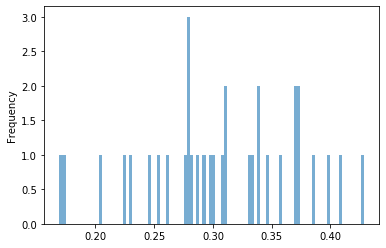

In [15]:
df_inclusive_subset['EigValuesReal_0'].plot.hist(bins=100, alpha=0.6)

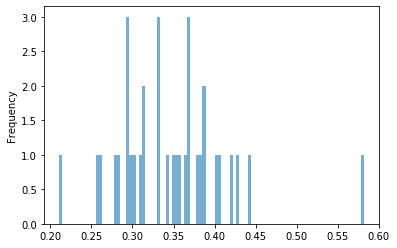

In [16]:
df_inclusive_subset['EigValuesReal_1'].plot.hist(bins=100, alpha=0.6)

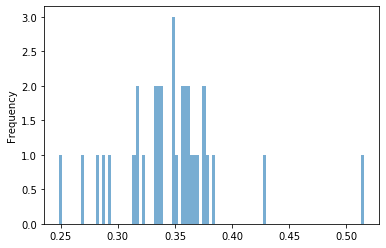

In [17]:
df_inclusive_subset['EigValuesReal_2'].plot.hist(bins=100, alpha=0.6)

<function matplotlib.pyplot.show(*args, **kw)>

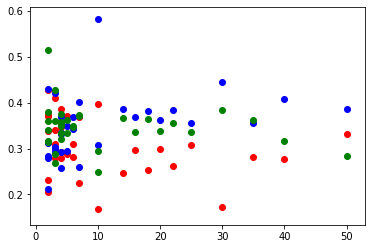

In [18]:
plt.scatter(df_inclusive_subset['<pT>'],df_inclusive_subset['EigValuesReal_0'],c='Red')
plt.scatter(df_inclusive_subset['<pT>'],df_inclusive_subset['EigValuesReal_1'],c='Blue')
plt.scatter(df_inclusive_subset['<pT>'],df_inclusive_subset['EigValuesReal_2'],c='Green')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

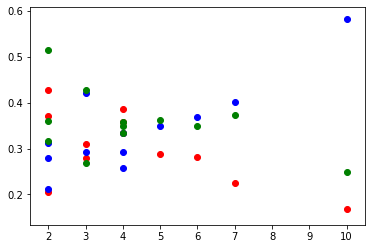

In [19]:
df_HE = df_inclusive_subset[df_inclusive_subset['Frame'] < 0.5]



plt.scatter(df_HE['<pT>'],df_HE['EigValuesReal_0'],c='Red')
plt.scatter(df_HE['<pT>'],df_HE['EigValuesReal_1'],c='Blue')
plt.scatter(df_HE['<pT>'],df_HE['EigValuesReal_2'],c='Green')
plt.show



<function matplotlib.pyplot.show(*args, **kw)>

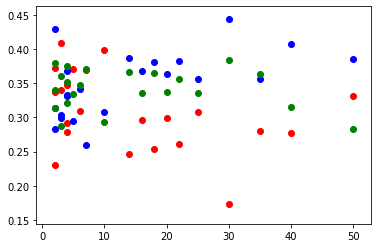

In [20]:
df_CS = df_inclusive_subset[df_inclusive_subset['Frame'] > 0.5]



plt.scatter(df_CS['<pT>'],df_CS['EigValuesReal_0'],c='Red')
plt.scatter(df_CS['<pT>'],df_CS['EigValuesReal_1'],c='Blue')
plt.scatter(df_CS['<pT>'],df_CS['EigValuesReal_2'],c='Green')
plt.show



In [21]:
def ProbeMatrixWithUncert( Rho11, Rho13, Rho22, Rho33, returnValue ):
    rho       = np.array([[uncertainties.ufloat(0.,0.),uncertainties.ufloat(0.,0.),uncertainties.ufloat(0.,0.)], 
                          [uncertainties.ufloat(0.,0.),uncertainties.ufloat(0.,0.),uncertainties.ufloat(0.,0.)],
                          [uncertainties.ufloat(0.,0.),uncertainties.ufloat(0.,0.),uncertainties.ufloat(0.,0.)]])
    rho[0][0] = Rho11
    rho[0][2] = Rho13
    rho[2][0] = Rho13
    rho[1][1] = Rho22
    rho[2][2] = Rho33
    if returnValue == 0:
        return rho 
    elif returnValue == 1:
        return rho[0][0]
    elif returnValue == 2:
        return rho[0][1]
    elif returnValue == 3:
        return rho[0][2]
    elif returnValue == 4:
        return rho[0][3]
    elif returnValue == 5:
        return rho[1][0]
    elif returnValue == 6:
        return rho[1][1]
    elif returnValue == 7:
        return rho[1][2]
    elif returnValue == 8:
        return rho[2][0]
    elif returnValue == 9:
        return rho[2][1]
    elif returnValue == 10:
        return rho[2][2]



In [22]:
df_inclusive['ProbeMatrixUncert'] = df_inclusive.apply(lambda x: ProbeMatrixWithUncert( x['Rho11withuncert'], x['Rho13withuncert'], x['Rho22withuncert'], x['Rho33withuncert'], 0 ), axis=1)
df_inclusive


,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho22withuncert,Rho13withuncert,Rho11withuncert,ProbeMatrix,EigValues,EigVecs,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2,ProbeMatrixUncert
0,7,0,2.0,-0.360,0.050,0.000,0.0900,0.0400,0.0000,0.2100,...,0.28+/-0.04,-0.0+/-0,0.2045454545454547+/-0,"[[0.2045454545454547, 0.0, -0.0], [0.0, 0.2803...","[0.2045454545454547, 0.2803030303030303, 0.515...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.204545,0.280303,0.515152,"[[0.2045454545454547+/-0, 0.0+/-0, -0.0+/-0], ..."
1,7,0,3.0,-0.200,0.010,0.000,0.1100,0.0500,0.0000,0.1300,...,0.29+/-0.05,-0.0+/-0,0.27857142857142847+/-0,"[[0.27857142857142847, 0.0, -0.0], [0.0, 0.292...","[0.27857142857142847, 0.29285714285714287, 0.4...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.278571,0.292857,0.428571,"[[0.27857142857142847+/-0, 0.0+/-0, -0.0+/-0],..."
2,7,0,4.0,0.000,0.000,0.000,0.1000,0.0400,0.0000,0.1000,...,0.33+/-0.04,-0.0+/-0,0.3333333333333334+/-0,"[[0.3333333333333334, 0.0, -0.0], [0.0, 0.3333...","[0.3333333333333334, 0.3333333333333333, 0.333...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.333333,0.333333,0.333333,"[[0.3333333333333334+/-0, 0.0+/-0, -0.0+/-0], ..."
3,7,1,2.0,-0.100,-0.040,0.000,0.1400,0.0800,0.0000,0.1300,...,0.28+/-0.07,-0.0+/-0,0.3379310344827586+/-0,"[[0.3379310344827586, 0.0, -0.0], [0.0, 0.2827...","[0.3379310344827586, 0.2827586206896552, 0.379...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.337931,0.282759,0.379310,"[[0.3379310344827586+/-0, 0.0+/-0, -0.0+/-0], ..."
4,7,1,3.0,-0.060,-0.030,0.000,0.1400,0.0800,0.0000,0.0700,...,0.30+/-0.06,-0.0+/-0,0.3401360544217687+/-0,"[[0.3401360544217687, 0.0, -0.0], [0.0, 0.2993...","[0.3401360544217687, 0.29931972789115646, 0.36...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.340136,0.299320,0.360544,"[[0.3401360544217687+/-0, 0.0+/-0, -0.0+/-0], ..."
5,7,1,4.0,-0.090,0.030,0.000,0.1000,0.0600,0.0000,0.0800,...,0.33+/-0.06,-0.0+/-0,0.29209621993127155+/-0,"[[0.29209621993127155, 0.0, -0.0], [0.0, 0.333...","[0.29209621993127155, 0.3333333333333333, 0.37...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.292096,0.333333,0.374570,"[[0.29209621993127155+/-0, 0.0+/-0, -0.0+/-0],..."
6,8,0,2.0,0.035,-0.037,-0.024,0.0480,0.0250,0.0320,0.2150,...,0.32+/-0.06,0.02+/-0.06,0.365+/-0.006,"[[0.3654036243822076, 0.0, 0.01581548599670510...","[0.3701921682409014, 0.3131686225333984, 0.316...","[[0.9570920264890529, -0.2897841486884299, 0.0...",0.370192,0.313169,0.316639,"[[0.365+/-0.006, 0.0+/-0, 0.02+/-0.06], [0.0+/..."
7,8,0,3.0,-0.085,-0.065,-0.080,0.0530,0.0260,0.0350,0.1890,...,0.27+/-0.09,0.05+/-0.06,0.358+/-0.017,"[[0.35849056603773594, 0.0, 0.0548885077186964...","[0.31003596742162237, 0.42066729158352356, 0.2...","[[-0.7496781758158655, -0.6618025632357404, 0....",0.310036,0.420667,0.269297,"[[0.358+/-0.017, 0.0+/-0, 0.05+/-0.06], [0.0+/..."
8,8,0,4.0,0.083,-0.003,-0.024,0.0660,0.0330,0.0430,0.1880,...,0.35+/-0.07,0.02+/-0.06,0.353+/-0.006,"[[0.3532273759325332, 0.0, 0.01556925072980862...","[0.3572781634829585, 0.2933867732669604, 0.349...","[[0.9677803733324292, -0.25179584784611486, 0....",0.357278,0.293387,0.349335,"[[0.353+/-0.006, 0.0+/-0, 0.02+/-0.06], [0.0+/..."
9,8,0,5.0,-0.036,0.055,-0.001,0.0580,0.0290,0.0390,0.1540,...,0.36+/-0.05,0.00+/-0.06,0.28812+/-0.00023,"[[0.2881241565452091, 0.0, 0.00067476383265856...","[0.2881167424532426, 0.3495350794091056, 0.362...","[[-0.9999396408622011, -0.010987021087287434, ...",0.288117,0.349535,0.362348,"[[0.28812+/-0.00023, 0.0+/-0, 0.00+/-0.06], [0..."


In [23]:
# df_inclusive[['EigValuesWithUncert','EigVecsWithUncert']] = df_inclusive.apply(lambda x: eig(x['ProbeMatrixUncert']  ), axis=1, result_type="expand")


In [24]:
import scipy

In [25]:
# df_inclusive['LogRho'] = df_inclusive.apply(lambda x: scipy.linalg.logm(x['ProbeMatrix']  ), axis=1, result_type="expand")
df_inclusive['Trace'] = df_inclusive.apply(lambda x: np.trace(x['ProbeMatrix']*x['ProbeMatrix']  ), axis=1, result_type="expand")
df_inclusive

,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho13withuncert,Rho11withuncert,ProbeMatrix,EigValues,EigVecs,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2,ProbeMatrixUncert,Trace
0,7,0,2.0,-0.360,0.050,0.000,0.0900,0.0400,0.0000,0.2100,...,-0.0+/-0,0.2045454545454547+/-0,"[[0.2045454545454547, 0.0, -0.0], [0.0, 0.2803...","[0.2045454545454547, 0.2803030303030303, 0.515...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.204545,0.280303,0.515152,"[[0.2045454545454547+/-0, 0.0+/-0, -0.0+/-0], ...",0.385790
1,7,0,3.0,-0.200,0.010,0.000,0.1100,0.0500,0.0000,0.1300,...,-0.0+/-0,0.27857142857142847+/-0,"[[0.27857142857142847, 0.0, -0.0], [0.0, 0.292...","[0.27857142857142847, 0.29285714285714287, 0.4...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.278571,0.292857,0.428571,"[[0.27857142857142847+/-0, 0.0+/-0, -0.0+/-0],...",0.347041
2,7,0,4.0,0.000,0.000,0.000,0.1000,0.0400,0.0000,0.1000,...,-0.0+/-0,0.3333333333333334+/-0,"[[0.3333333333333334, 0.0, -0.0], [0.0, 0.3333...","[0.3333333333333334, 0.3333333333333333, 0.333...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.333333,0.333333,0.333333,"[[0.3333333333333334+/-0, 0.0+/-0, -0.0+/-0], ...",0.333333
3,7,1,2.0,-0.100,-0.040,0.000,0.1400,0.0800,0.0000,0.1300,...,-0.0+/-0,0.3379310344827586+/-0,"[[0.3379310344827586, 0.0, -0.0], [0.0, 0.2827...","[0.3379310344827586, 0.2827586206896552, 0.379...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.337931,0.282759,0.379310,"[[0.3379310344827586+/-0, 0.0+/-0, -0.0+/-0], ...",0.338026
4,7,1,3.0,-0.060,-0.030,0.000,0.1400,0.0800,0.0000,0.0700,...,-0.0+/-0,0.3401360544217687+/-0,"[[0.3401360544217687, 0.0, -0.0], [0.0, 0.2993...","[0.3401360544217687, 0.29931972789115646, 0.36...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.340136,0.299320,0.360544,"[[0.3401360544217687+/-0, 0.0+/-0, -0.0+/-0], ...",0.335277
5,7,1,4.0,-0.090,0.030,0.000,0.1000,0.0600,0.0000,0.0800,...,-0.0+/-0,0.29209621993127155+/-0,"[[0.29209621993127155, 0.0, -0.0], [0.0, 0.333...","[0.29209621993127155, 0.3333333333333333, 0.37...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.292096,0.333333,0.374570,"[[0.29209621993127155+/-0, 0.0+/-0, -0.0+/-0],...",0.336734
6,8,0,2.0,0.035,-0.037,-0.024,0.0480,0.0250,0.0320,0.2150,...,0.02+/-0.06,0.365+/-0.006,"[[0.3654036243822076, 0.0, 0.01581548599670510...","[0.3701921682409014, 0.3131686225333984, 0.316...","[[0.9570920264890529, -0.2897841486884299, 0.0...",0.370192,0.313169,0.316639,"[[0.365+/-0.006, 0.0+/-0, 0.02+/-0.06], [0.0+/...",0.334877
7,8,0,3.0,-0.085,-0.065,-0.080,0.0530,0.0260,0.0350,0.1890,...,0.05+/-0.06,0.358+/-0.017,"[[0.35849056603773594, 0.0, 0.0548885077186964...","[0.31003596742162237, 0.42066729158352356, 0.2...","[[-0.7496781758158655, -0.6618025632357404, 0....",0.310036,0.420667,0.269297,"[[0.358+/-0.017, 0.0+/-0, 0.05+/-0.06], [0.0+/...",0.339579
8,8,0,4.0,0.083,-0.003,-0.024,0.0660,0.0330,0.0430,0.1880,...,0.02+/-0.06,0.353+/-0.006,"[[0.3532273759325332, 0.0, 0.01556925072980862...","[0.3572781634829585, 0.2933867732669604, 0.349...","[[0.9677803733324292, -0.25179584784611486, 0....",0.357278,0.293387,0.349335,"[[0.353+/-0.006, 0.0+/-0, 0.02+/-0.06], [0.0+/...",0.335274
9,8,0,5.0,-0.036,0.055,-0.001,0.0580,0.0290,0.0390,0.1540,...,0.00+/-0.06,0.28812+/-0.00023,"[[0.2881241565452091, 0.0, 0.00067476383265856...","[0.2881167424532426, 0.3495350794091056, 0.362...","[[-0.9999396408622011, -0.010987021087287434, ...",0.288117,0.349535,0.362348,"[[0.28812+/-0.00023, 0.0+/-0, 0.00+/-0.06], [0...",0.336481


In [26]:
# df_inclusive['Degree'] = df_inclusive.apply(lambda x: math.sqrt(1.5*x['Trace']-0.5)  , axis=1, result_type="expand")
# df_inclusive
print(df_inclusive['Rho11'])


0     0.204545
1     0.278571
2     0.333333
3     0.337931
4     0.340136
5     0.292096
6     0.365404
7     0.358491
8     0.353227
9     0.288124
10    0.250344
11    0.253463
12    0.353764
13    0.374373
14    0.346218
15    0.360104
16    0.369449
17    0.363545
18    0.396520
19    0.373532
20    0.285324
21    0.253605
22    0.288481
23    0.315508
24    0.246186
25    0.302927
26    0.255349
27    0.299250
28    0.261666
29    0.308709
30    0.174180
31    0.281843
32    0.278988
33    0.344993
Name: Rho11, dtype: float64


In [27]:
print(df_inclusive['Rho22'])


0     0.280303
1     0.292857
2     0.333333
3     0.282759
4     0.299320
5     0.333333
6     0.316639
7     0.269297
8     0.349335
9     0.362348
10    0.374140
11    0.248970
12    0.313791
13    0.287387
14    0.320893
15    0.333986
16    0.370709
17    0.293723
18    0.360472
19    0.357030
20    0.349488
21    0.339430
22    0.352362
23    0.347594
24    0.366852
25    0.335602
26    0.364389
27    0.337423
28    0.355686
29    0.335818
30    0.383339
31    0.363144
32    0.315531
33    0.283265
Name: Rho22, dtype: float64


In [28]:
print(df_inclusive['Rho33'])


0     0.515152
1     0.428571
2     0.333333
3     0.379310
4     0.360544
5     0.374570
6     0.317957
7     0.372213
8     0.297438
9     0.349528
10    0.375516
11    0.497566
12    0.332445
13    0.338240
14    0.332889
15    0.305909
16    0.259843
17    0.342732
18    0.243008
19    0.269438
20    0.365188
21    0.406964
22    0.359157
23    0.336898
24    0.386963
25    0.361470
26    0.380262
27    0.363327
28    0.382648
29    0.355473
30    0.442481
31    0.355014
32    0.405481
33    0.371742
Name: Rho33, dtype: float64


In [29]:
print(df_inclusive['Rho13'])


0    -0.000000
1    -0.000000
2    -0.000000
3    -0.000000
4    -0.000000
5    -0.000000
6     0.015815
7     0.054889
8     0.015569
9     0.000675
10   -0.061210
11   -0.166230
12   -0.027315
13    0.050184
14   -0.003999
15    0.027424
16    0.005669
17    0.043639
18    0.077067
19    0.037448
20    0.017065
21    0.063313
22    0.027183
23   -0.012032
24   -0.000693
25    0.020422
26    0.011732
27    0.000682
28    0.006222
29   -0.002033
30   -0.020916
31   -0.009485
32   -0.015460
33    0.024005
Name: Rho13, dtype: float64
